In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Configure numbers so easier to read
pd.options.display.float_format = '{:20.2f}'.format

# Show all columns on output
pd.set_option('display.max_columns', 999)

# Data Exploration

First, let's load in the first sheet of data as a dataframe (2009-2010) to see what we are working with.

In [2]:
df = pd.read_excel('./data/online_retail_II.xlsx', sheet_name=0)
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.00,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.00,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.00,United Kingdom


Next, we can learn more about the type of data we are working with and what type of format they are in.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


Looks good! All our string columns are represented as `objects`, the `InvoiceDate` is automatically detected as a `datetime` which is awesome, and our numeric fields seem okay too. It's odd to see a `Customer ID` column as a float (I would expect an integer instead!), we'll have to take a look at that later.

Okay, let's now look at the basic statistics for the quantitative data.

In [4]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.00,525461,525461.00,417534.00
mean,10.34,2010-06-28 11:37:36.845017856,4.69,15360.65
min,-9600.00,2009-12-01 07:45:00,-53594.36,12346.00
25%,1.00,2010-03-21 12:20:00,1.25,13983.00
50%,3.00,2010-07-06 09:51:00,2.10,15311.00
75%,10.00,2010-10-15 12:45:00,4.21,16799.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,107.42,NaN,146.13,1680.81


Now that's interesting, a minus value as the minimum quantity and price? Suspicious. The maximum `price` seems a little high too. This is sales data minus values shouldn't exist, surely? Something can't be right there. We'll have to investigate that.

Now let's check out the qualitative data.

In [5]:
df.describe(include=[object])

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


Hmmm... there looks to be some missing values in the `Description` column and a minor disparity between the frequencies. We'll take a look at that.

## Missing Values & Oddities

Alright, next let's take a look at our missing data.

In [6]:
df.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [7]:
df.isna().sum().sum()

np.int64(110855)

It looks like only two of our columns have missing data with a combined total of `110,855` missing cells. `Customer ID` is our biggest concern so that's check that out first.

In [8]:
df[df["Customer ID"].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


This data has some weird behaviour going on. Minus quanities, with 0 pricing - could these perhaps be thefts or stock write-offs? It's hard to tell.

Hmmm.. We'll that's annoying. Invoices 577 onwards in our sample seem to be valid transactions, but without a `Customer ID` we cannot use them, there's no way to infer which transaction the customer relates to. Our only option here is to drop these missing values from our main analysis.

Before we drop them though, let's take a look at these negative quantities.

In [9]:
df[df["Quantity"] < 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321.00,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.00,United Kingdom


Okay, so a lot of these invoices look like cancellations (invoices starting with a `C` means cancellation). That's expected based on what we know about our initial understanding. Let's see how many records we are looking at.

In [10]:
negative_quantites = df[df["Quantity"] < 0]
negative_quantites.shape

(12326, 8)

In [11]:
negative_quantites["Invoice"].str.startswith('C').sum(), negative_quantites["Invoice"].str.startswith('C').isna().sum()

(10205, np.int64(2121))

Out of all of them (less than 0 prices), about 20% relate to missing records. Let's explore things further and see what other types of invoice patterns we have. We should only have two formats: `6 numbers`, `C + 6 numbers`.

Firstly, let's change the `Invoice` column to a string so we can use REGEX. Next, we'll 'remove' the digits and see what letters we have left.

In [12]:
df["Invoice"] = df["Invoice"].astype("str")

In [13]:
df["Invoice"].str.replace("[0-9]", "", regex=True).unique()

array(['', 'C', 'A'], dtype=object)

Well that's unexpected! What is this `A` all about? Let's take a look.

In [14]:
df[df["Invoice"].str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


These look like pure accounting transactions and hold no real value in analysing our customers behaviour. The large negative price values would also skew our results drastically. We'll remove these from our analysis. 

Now that we've seen some issues with the `InvoiceNo`, let's check out the `StockCode` column and make sure that its in the correct format too. This should only consist of `5` digit numeric codes.

In [15]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.00,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.00,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.00,United Kingdom


Just by taking another quick look at some of the records, we can immediately see some issues with the `StockCode`. Let's do a deeper dive into it. Using the same tactic as before by 'removing' our numbers. 

In [16]:
df["StockCode"] = df["StockCode"].astype("str")

In [17]:
df["StockCode"].str.replace("[0-9]", "", regex=True).unique()

array(['', 'P', 'W', 'C', 'B', 'F', 'L', 'S', 'A', 'N', 'POST', 'E', 'J',
       'D', 'G', 'LP', 'BL', 'K', 'H', 'GR', 'M', 'DCGS', 'DOT', 'U', 'b',
       'w', 'c', 'a', 'f', 'bl', 's', 'p', 'R', 'V', 'T', 'I',
       'BANK CHARGES', 'O', 'Z', 'TEST', 'gift__', 'DCGSN', 'm', 'PADS',
       'Y', 'HC', 'e', 'd', 'ADJUST', 'DCGSSGIRL', 'GIFT', 'DCGSLBOY',
       'k', 'g', 'DCGSSBOY', 'DCGSLGIRL', 'j', 'l', 'n', 'J ', 'SP',
       'AMAZONFEE'], dtype=object)

In [18]:
df[(df["StockCode"].str.match('^\\d{5}$') == False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.00,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.00,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.00,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.00,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.00,United Kingdom


Here we can see that numbers are not the only item in the `StockCode` column. Some of them look like specific sale events, you also have test records and bank charges, which can be removed. The single letters look like valid transactions so we will keep them in our analysis. Let's now check the other values, such as `POST`, `DOT`, `PADS`, etc.

Regex notes:
- `^\\d{5}$` - 5 digits only (`[0-9]`), this is what we expect our `StockCode` values to be
- `^\\d{5}[a-zA-Z]+$` - any values starting with 5 digits and ending in text

In [19]:
odd_stockcode_data = df[(df["StockCode"].str.match('^\\d{5}$') == False) & (df["StockCode"].str.match('^\\d{5}[a-zA-Z]+$') == False)]
odd_stockcode_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,12682.00,France
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.00,USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.00,12362.00,Belgium
625,489526,POST,POSTAGE,6,2009-12-01 11:50:00,18.00,12533.00,Germany
735,C489535,D,Discount,-1,2009-12-01 12:11:00,9.00,15299.00,United Kingdom
...,...,...,...,...,...,...,...,...
524776,538147,M,Manual,1,2010-12-09 16:11:00,15.00,13090.00,United Kingdom
524887,538148,DOT,DOTCOM POSTAGE,1,2010-12-09 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-12-09 16:27:00,620.68,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-12-09 16:31:00,822.94,NaN,United Kingdom


In [20]:
odd_stockcode_data["StockCode"].unique()

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

To keep things simple, I've analysed all of the above unique codes in the cell below (replacing the code to prevent the notebook from getting too long). Here's what we've learned:

| Code              | Description                                                   | Exclude? | 
|-------------------|---------------------------------------------------------------|----------| 
| POST              | Looks valid, postage charges                                  | &check;  |
| D                 | Looks valid, discount values                                  | &check;  |
| DCGSXXXX          | Looks valid, some quantities are negative, customer ID null   | &check;  |
| DOT               | Looks valid, dotcom postage charges                           | &check;  |
| M, m              | Looks valid, manual transactions                              | &check;  |
| C2                | Not sure, Carriage transaction                                | &check;  |
| BANK CHARGES, B   | Bank charges                                                  | &check;  |
| TESTXXX           | Test data                                                     | &check;  |
| GIFT, gift__XXX   | Gift card purchases, another analysis(?), customer ID null    | &check;  |
| PADS              | Looks valid, pad related projects                             | &cross;  |
| ADJUSTX           | Manual account adjustments by admins                          | &check;  |
| C3                | Not sure, only 1 transaction                                  | &check;  |
| S                 | Samples sent to customer                                      | &check;  |
| SP1002            | Special request items, look valid, 3 items, 1 Cutomer ID null | &check;  |
| AMAZONFEE         | Amazon shipping fees, customer ID null                        | &check;  |

We'll keep the `PADS` but remove everything else. That about does it for the `StockCode` column. Onto data cleaning!

In [21]:
odd_stockcode_data[odd_stockcode_data["StockCode"].str.contains("AMAZONFEE")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
440688,C531400,AMAZONFEE,AMAZON FEE,-1,2010-11-08 10:08:00,6706.71,NaN,United Kingdom
440698,531411,AMAZONFEE,AMAZON FEE,1,2010-11-08 10:11:00,6706.71,NaN,United Kingdom
517452,C537600,AMAZONFEE,AMAZON FEE,-1,2010-12-07 12:41:00,1.00,NaN,United Kingdom
517953,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom
517955,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
519170,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,NaN,United Kingdom
519251,C537647,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:41:00,5519.25,NaN,United Kingdom
519294,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NaN,United Kingdom
519295,C537652,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:51:00,6706.71,NaN,United Kingdom


### Notes For Data Cleaning

Row removal -

- Has the following `StockCodes`:

    `['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004', 'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001', 'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002', 'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70', 'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027', 'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT', 'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY', 'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B', 'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE']`

- Has a missing `Customer ID`
- `InvoiceNo` starts with `A` or `C`



## Data Cleaning

Now let's move onto cleaning are data based on the above requirements. We start by making a copy of our original data before cleaning.

In [22]:
cleaned_df = df.copy()
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


We then create a mask of our `InvoiceNo` column that performs the required updates.  

In [23]:
invoice_mask = cleaned_df["Invoice"].str.match("^\\d{6}$") == True

And, do the same for the `StockCode` column then apply the masks to the cleaned DataFrame.

In [24]:
stockcode_mask = (
    (cleaned_df["StockCode"].str.match('^\\d{5}$') == True)  # 5 digits
    | (cleaned_df["StockCode"].str.match('^\\d{5}[a-zA-Z]+$') == True)  # 5 digits with text after it
    | (cleaned_df["StockCode"].str.match('^PADS$') == True) # PADS data
)

In [25]:
cleaned_df = cleaned_df[invoice_mask]
cleaned_df = cleaned_df[stockcode_mask]
cleaned_df

C:\Users\rpart\AppData\Local\Temp\ipykernel_19476\4045565412.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[stockcode_mask]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


Now we remove the missing `Customer ID` rows.

In [26]:
cleaned_df.dropna(subset=["Customer ID"], inplace=True)

In [27]:
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


Perfect! Next, let's take a look at our column stats to see our changes.

In [28]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406337.00,406337,406337.00,406337.00
mean,13.62,2010-07-01 10:11:06.543288320,2.99,15373.63
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14004.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.37


In [29]:
cleaned_df.describe(include=[object])

,Invoice,StockCode,Description,Country
count,406337,406337,406337,406337
unique,18966,4007,4433,37
top,500356,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,270,3153,3153,370487


Awesome! The minimum `quantity` and `price` are now back to normal and everything else looks great. Although, a `price` of 0 is a little odd. There shouldn't be any freebies! Let's take a look.

In [30]:
cleaned_df[cleaned_df["Price"] == 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.00,16126.00,United Kingdom
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.00,15658.00,United Kingdom
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.00,14108.00,United Kingdom
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.00,14108.00,United Kingdom
32916,492079,85042,ANTIQUE LILY FAIRY LIGHTS,8,2009-12-15 13:49:00,0.00,15070.00,United Kingdom
40101,492760,21143,ANTIQUE GLASS HEART DECORATION,12,2009-12-18 14:22:00,0.00,18071.00,United Kingdom
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.00,14258.00,United Kingdom
48342,493899,22355,"CHARLOTTE BAG , SUKI DESIGN",10,2010-01-08 10:43:00,0.00,12417.00,Belgium
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.00,16858.00,United Kingdom
111348,500073,21662,VINTAGE GLASS COFFEE CADDY,1,2010-03-04 11:44:00,0.00,13047.00,United Kingdom


These are definitely red flags. 648 items for free?! I'm not sure why these are here, I'd be talking to management about these ones! Let's remove them and check the stats again.

In [31]:
cleaned_df = cleaned_df[cleaned_df["Price"] > 0]

In [32]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406309.00,406309,406309.00,406309.00
mean,13.62,2010-07-01 10:14:25.869572352,2.99,15373.72
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14006.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.33


Er... the price appears to still be `0`. Let's just quickly check that and make sure it is larger than it.

In [33]:
cleaned_df["Price"].min()

np.float64(0.001)

In [34]:
cleaned_df[(cleaned_df["Price"] > 0) & (cleaned_df["Price"] < 1)]["Price"].unique()

array([0.85 , 0.65 , 0.98 , 0.42 , 0.72 , 0.55 , 0.38 , 0.21 , 0.75 ,
       0.95 , 0.29 , 0.34 , 0.19 , 0.64 , 0.37 , 0.1  , 0.14 , 0.36 ,
       0.18 , 0.12 , 0.08 , 0.06 , 0.5  , 0.25 , 0.48 , 0.32 , 0.67 ,
       0.22 , 0.16 , 0.04 , 0.79 , 0.09 , 0.53 , 0.17 , 0.7  , 0.001,
       0.4  , 0.3  , 0.15 , 0.88 , 0.63 , 0.24 , 0.11 , 0.45 , 0.35 ,
       0.8  , 0.6  , 0.52 , 0.2  , 0.66 , 0.07 , 0.87 , 0.62 , 0.78 ,
       0.27 , 0.13 , 0.31 , 0.33 , 0.05 , 0.03 , 0.89 , 0.74 , 0.9  ,
       0.73 ])

Okay, so it looks like the smallest item value sold is `0.001` which doesn't seem right. That's a 10th of a penny!

In [35]:
print(cleaned_df[cleaned_df["Price"] == 0.001].shape[0])
cleaned_df[cleaned_df["Price"] == 0.001]

14


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
62299,494914,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-19 17:04:00,0.00,16705.00,United Kingdom
74731,496222,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-29 13:53:00,0.00,13583.00,United Kingdom
77702,496473,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-01 15:38:00,0.00,17350.00,United Kingdom
79794,496643,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-03 11:58:00,0.00,13408.00,United Kingdom
90798,497935,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-15 10:47:00,0.00,13408.00,United Kingdom
97716,498562,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-21 12:03:00,0.00,15182.00,United Kingdom
101718,499056,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-24 13:46:00,0.00,13765.00,United Kingdom
104480,499399,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-26 13:26:00,0.00,14459.00,United Kingdom
123947,501176,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-03-15 11:00:00,0.00,14857.00,United Kingdom
156809,504332,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-04-12 16:30:00,0.00,12671.00,Germany


It looks like they are cushion related. I guess nothing can be free with this company? We'll remove them from our analysis too.

In [36]:
cleaned_df = cleaned_df[cleaned_df["Price"] != 0.001]
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [37]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406295.00,406295,406295.00,406295.00
mean,13.62,2010-07-01 10:18:05.997415424,2.99,15373.75
min,1.00,2009-12-01 07:45:00,0.03,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14006.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.33


In [38]:
cleaned_df.describe(include=[object])

,Invoice,StockCode,Description,Country
count,406295,406295,406295,406295
unique,18966,4006,4432,37
top,500356,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,270,3153,3153,370455


Much better! I'm okay with 3p items! Let's quickly note the number of rows removed before continuing to the next step.

In [39]:
len(cleaned_df) / len(df)

0.7732162805612596

We removed about `23%` of our original data. Cool! Let's move onto feature engineering.

# Feature Engineering

This is where the real fun begins! Now that our data is cleaned, we need to create some extra features that help us to understand our customers buying habits. Here's what we need:

- The number of purchases the customer has made (frequency)
- The amount they have spent overall (monetary value)
- The date of the last purchase they made (last invoice date)

We'll first start by creating a `SalesTotal` helper column and then create an aggregated DataFrame to group our records.

In [40]:
cleaned_df.reset_index(inplace=True, drop=True)

In [41]:
cleaned_df["SalesTotal"] = cleaned_df["Quantity"] * cleaned_df["Price"]
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SalesTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
406290,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom,5.90
406291,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
406292,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
406293,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,7.50


To achieve our desired results, we group the `Customer ID` with some new columns:
- `MonetaryValue` - for the total cost of the customers order
- `Frequency` - the number of unique invoices
- `LastInvoiceDate` - the last invoice (purchase made) generated by that customer

In [42]:
aggregated_df = cleaned_df.groupby(by="Customer ID", as_index=False) \
                .agg(
                    MonetaryValue=("SalesTotal", "sum"), 
                    Frequency=("Invoice", "nunique"),
                    LastInvoiceDate=("InvoiceDate", "max")
                )
aggregated_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate
0,12346.00,169.36,2,2010-06-28 13:53:00
1,12347.00,1323.32,2,2010-12-07 14:57:00
2,12348.00,221.16,1,2010-09-27 14:59:00
3,12349.00,2221.14,2,2010-10-28 08:23:00
4,12351.00,300.93,1,2010-11-29 15:23:00
...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00
4281,18284.00,411.68,1,2010-10-04 11:33:00
4282,18285.00,377.00,1,2010-02-17 10:24:00
4283,18286.00,1246.43,2,2010-08-20 11:57:00


Perfect! Here we can see that we have 4,285 unique customers. Let's also add a `Recency` column. For this dataset, we'll use the last invoice date, but normally, we'd use the date of the analysis (e.g., today's date). However, that doesn't make sense given the age of this dataset.

Also, to keep things simple, we'll specify the recency in days. It's easier to work with computationally.

In [43]:
max_invoice_date = aggregated_df["LastInvoiceDate"].max()

aggregated_df["RecencyDays"] = (max_invoice_date - aggregated_df['LastInvoiceDate']).dt.days
aggregated_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,RecencyDays
0,12346.00,169.36,2,2010-06-28 13:53:00,164
1,12347.00,1323.32,2,2010-12-07 14:57:00,2
2,12348.00,221.16,1,2010-09-27 14:59:00,73
3,12349.00,2221.14,2,2010-10-28 08:23:00,42
4,12351.00,300.93,1,2010-11-29 15:23:00,10
...,...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00,17
4281,18284.00,411.68,1,2010-10-04 11:33:00,66
4282,18285.00,377.00,1,2010-02-17 10:24:00,295
4283,18286.00,1246.43,2,2010-08-20 11:57:00,111


# Visual Exploration

Okay, now let's start visualising our data's distributions and identify any outliers. We'll start with a histogram.

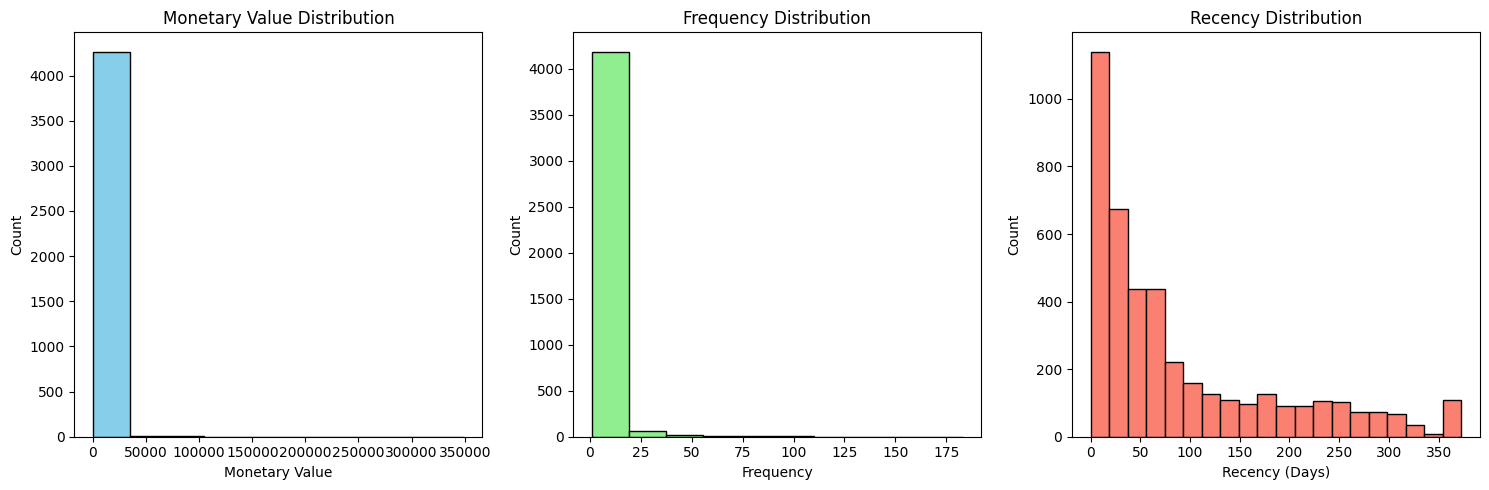

In [44]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_df['RecencyDays'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency (Days)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Wow! Our monetary value and frequency data is heavily skewed to a single bin, while our recency has a more clearly defined right-skew. Let's look at a boxplot next.

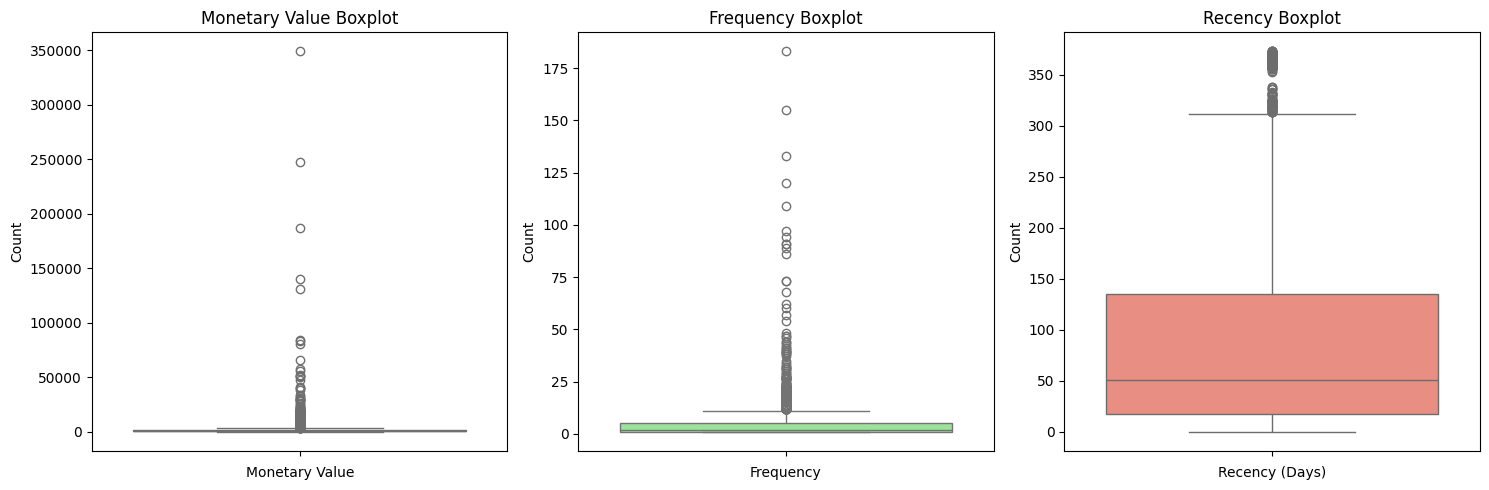

In [45]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.boxplot(aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.boxplot(aggregated_df['RecencyDays'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency (Days)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

It looks like there are a **LOT** of high valued outliers. We'll extract the `MonetaryValue` and `Frequency` outliers shortly and store them in a separate DataFrame. We can then explore them separately.

You may be wondering, why don't we just drop them from our analysis? Well, these are high-value frequent spenders of the business. Any business wants more of these types of customers, so it's important we explore these separately.

To get our outliers, we need to identify the Interquartile Range (IQR) of our records (the size of the box) and then use it to extract the values above the minimum (`Q1 - 1.5 * IQR`, bottom line) and maximum (`Q3 + 1.5 * IQR`, top line) thresholds. We'll do that next, starting with the `MonetaryValue`.

In [46]:
M_Q1 = aggregated_df["MonetaryValue"].quantile(q=0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(q=0.75)
M_IQR = M_Q3 - M_Q1
M_Q1, M_Q3, M_IQR

(np.float64(307.56), np.float64(1704.29), np.float64(1396.73))

In [47]:
max_threshold = M_Q3 + 1.5 * M_IQR
min_threshold = M_Q1 - 1.5 * M_IQR

In [48]:
monetary_outliers_df = aggregated_df[(aggregated_df["MonetaryValue"] > max_threshold) | (aggregated_df["MonetaryValue"] < min_threshold)].copy()

In [49]:
monetary_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,RecencyDays
count,423.00,423.00,423.00,423,423.00
mean,15103.04,12188.10,17.17,2010-11-09 12:26:02.978723328,30.04
min,12357.00,3802.04,1.00,2009-12-10 18:03:00,0.00
25%,13622.00,4605.94,8.00,2010-11-08 13:17:30,3.00
50%,14961.00,6191.32,12.00,2010-11-26 12:19:00,13.00
75%,16692.00,10273.24,18.00,2010-12-06 10:34:30,31.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,364.00
std,1728.66,25830.85,19.73,NaN,51.54


We'll do the same for the `Frequency` values but simplify this with a utility function (it does the same thing as above). 

In [50]:
from utils import get_outliers

frequency_outliers_df = get_outliers(aggregated_df, "Frequency")

In [51]:
frequency_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,RecencyDays
count,279.00,279.00,279.00,279,279.00
mean,15352.66,14409.71,23.81,2010-11-23 11:06:20.645161216,16.09
min,12437.00,1094.39,12.00,2010-05-12 16:51:00,0.00
25%,13800.00,4331.56,13.00,2010-11-20 13:14:30,2.00
50%,15465.00,6615.77,17.00,2010-12-02 10:46:00,7.00
75%,16828.50,11692.41,23.00,2010-12-07 11:08:30,19.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,211.00
std,1748.43,31381.74,21.93,NaN,26.59


Here's what we can learn from these outliers: 

- The lowest customer order count is 12 and it's maximum is 183 - that's a huge difference!
- The lowest monetary value a customer has spent is £1,094.39 and the highest is £349,164.35 (wow).

Keep in mind, there may be some overlap/differences for these outliers (we can already see that in the minimum monetary value for both variables). We'll look at this again later. We'll get our non-outlier data next.

In [52]:
non_outliers_df = aggregated_df[
    (~aggregated_df.index.isin(monetary_outliers_df.index)) &
    (~aggregated_df.index.isin(frequency_outliers_df.index))
].copy()

non_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,RecencyDays
count,3809.00,3809.00,3809.00,3809,3809.00
mean,15376.48,885.50,2.86,2010-09-03 11:16:46.516146176,97.08
min,12346.00,1.55,1.00,2009-12-01 10:49:00,0.00
25%,13912.00,279.91,1.00,2010-07-08 14:48:00,22.00
50%,15389.00,588.05,2.00,2010-10-12 16:25:00,58.00
75%,16854.00,1269.05,4.00,2010-11-17 13:14:00,154.00
max,18287.00,3788.21,11.00,2010-12-09 20:01:00,373.00
std,1693.20,817.67,2.24,NaN,98.11


From our `4,285` customers, we've removed  `476` outliers -> new total = `3809` customers. 

For reference, the collated count is `702` for our outliers (across the `MonetaryValues` and `Frequency` columns), but as expected, there is significant overlap.

We can still see a little bit of variability in the data - mean of  `885.50` vs standard deviation (std) of `817.67` - but it's a lot better than what we started with! Let's visualise this data again.

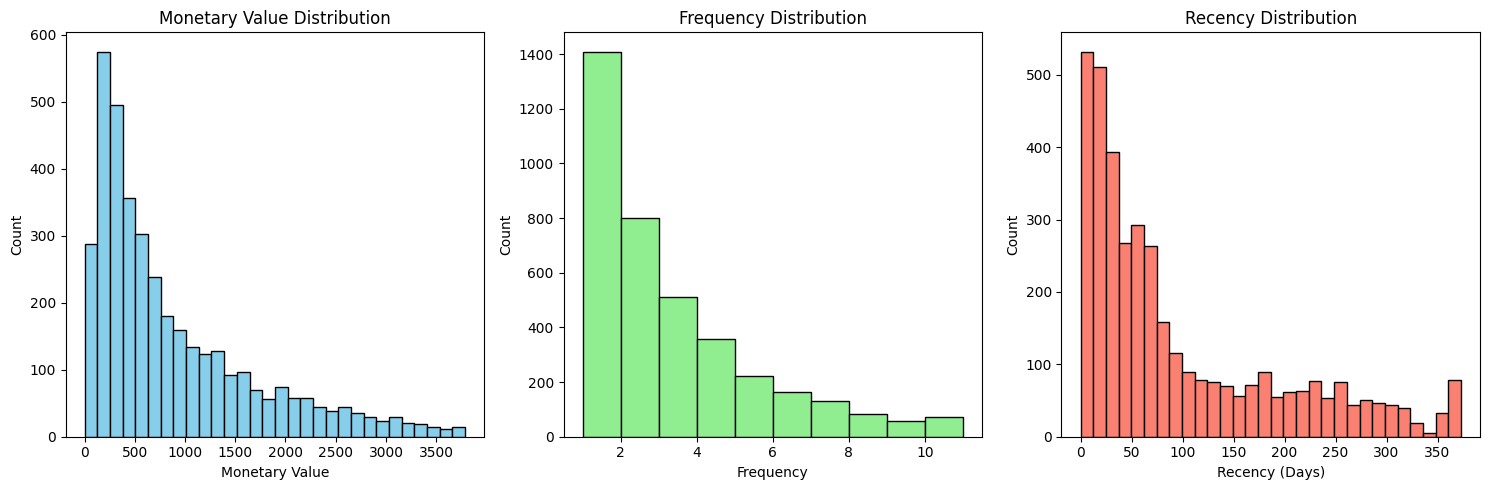

In [53]:
from utils import plot_histograms, HistogramDetails

plot_histograms(non_outliers_df, details=[
    HistogramDetails(column="MonetaryValue", bins=30, color='skyblue', title="Monetary Value Distribution", xlabel='Monetary Value', ylabel='Count'),
    HistogramDetails(column="Frequency", bins=10, color='lightgreen', title="Frequency Distribution", xlabel='Frequency', ylabel='Count'),
    HistogramDetails(column="RecencyDays", bins=30, color='salmon', title="Recency Distribution", xlabel='Recency (Days)', ylabel='Count'),
])

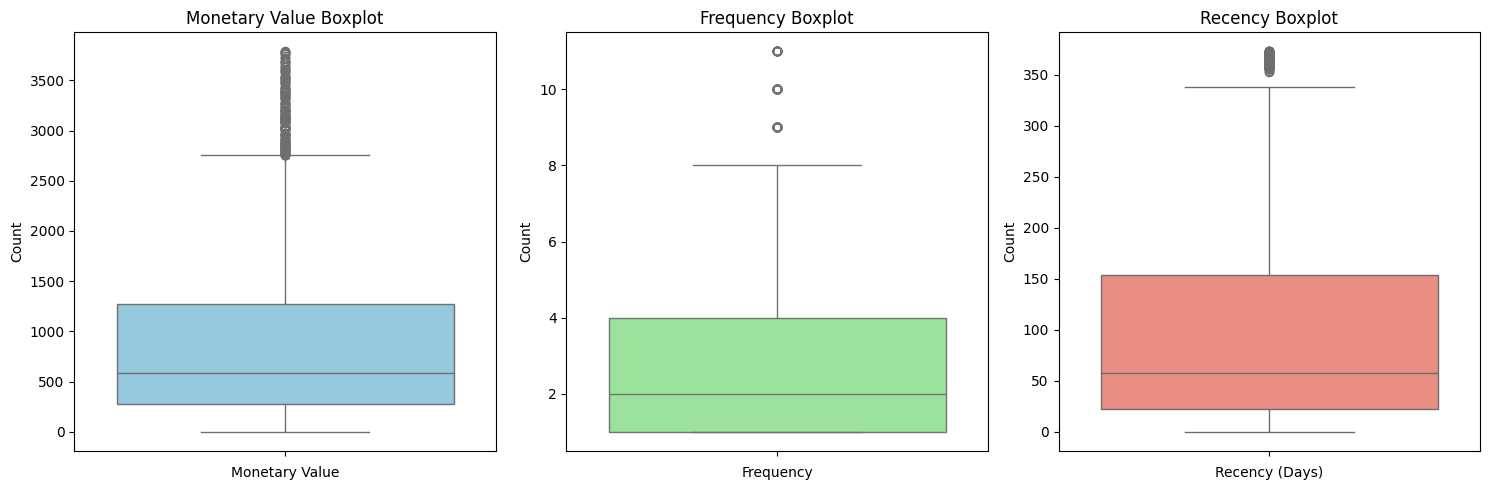

In [54]:
from utils import plot_boxes, BoxplotDetails

plot_boxes(non_outliers_df, details=[
    BoxplotDetails(column="MonetaryValue", color='skyblue', title="Monetary Value Boxplot", xlabel='Monetary Value', ylabel='Count'),
    BoxplotDetails(column="Frequency", color='lightgreen', title="Frequency Boxplot", xlabel='Frequency', ylabel='Count'),
    BoxplotDetails(column="RecencyDays", color='salmon', title="Recency Boxplot", xlabel='Recency (Days)', ylabel='Count'),
])

That's more like it! Now we can see a clear distribution across our data.

From the histograms we can see that there are a lot of purchases between `0 - £500` that make up most of the customer monetary value. This makes sense! By human nature, we often make smaller frequent purchases over a longer period of time.

From the boxplots, we can still see a lot of high-value outliers (specifically in `MonetaryValue`), but have a better indication of the spread of our data. For example, most customers have made `0 - 4` purchases in the year and spent between `£250 - £1250`. 

Great! So, that's comparing two variables at a time, but what about comparing them altogether? Let's give it a try!

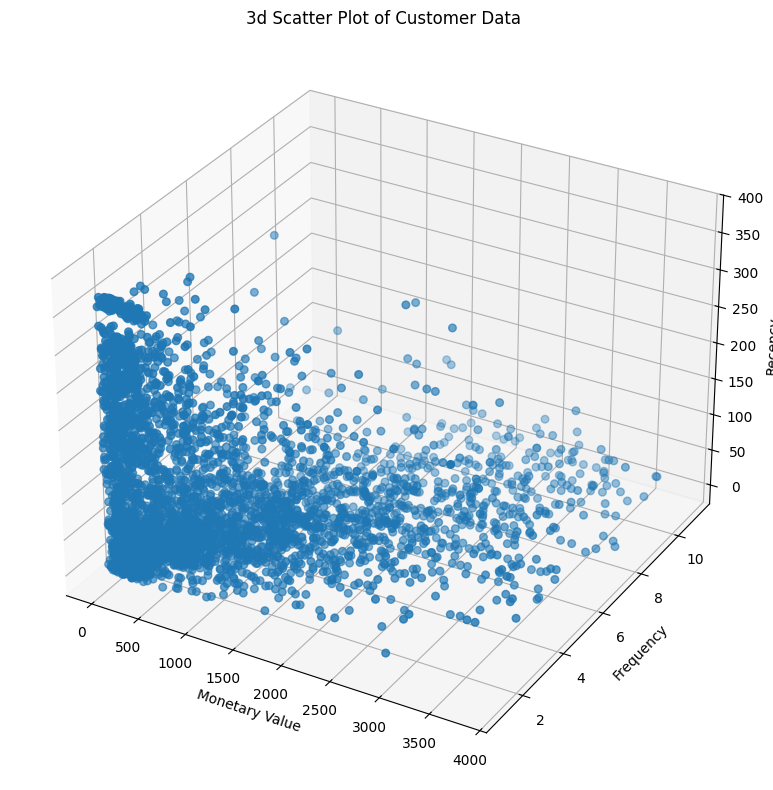

In [55]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(
    non_outliers_df["MonetaryValue"], 
    non_outliers_df["Frequency"], 
    non_outliers_df["RecencyDays"], 
    s=30,
)

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("3d Scatter Plot of Customer Data")

plt.tight_layout()
plt.show()

Hmmm... this plot is a little difficult to interpret. What would be great is if we could see the data split into clusters.

To do that, we first need to put our data onto the same scale using a feature scaling technique. There are two main approaches: `Standardisation` and `Normalisation`.

Standardisation transforms data to have a `mean = 0` and `std = 1`. While, `Normalisation` scales data to a specified range, e.g., `[0, 1]` or `[-1, 1]`. Our data is very clearly distributed and we don't want to change them so we will use `Standardisation` here.

In [56]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "RecencyDays"]])
scaled_data

array([[-0.87594534, -0.38488934,  0.68214853],
       [ 0.53551441, -0.38488934, -0.96925093],
       [-0.81258645, -0.83063076, -0.24548944],
       ...,
       [-0.62197163, -0.83063076,  2.01753946],
       [ 0.44146683, -0.38488934,  0.14187587],
       [ 1.72488782,  0.50659348, -0.81634357]])

In [57]:
scaled_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=["MonetaryValue", "Frequency", "RecencyDays"])
scaled_df

,MonetaryValue,Frequency,RecencyDays
0,-0.88,-0.38,0.68
1,0.54,-0.38,-0.97
2,-0.81,-0.83,-0.25
3,1.63,-0.38,-0.56
4,-0.72,-0.83,-0.89
...,...,...,...
4280,-0.30,1.40,-0.82
4281,-0.58,-0.83,-0.32
4282,-0.62,-0.83,2.02
4283,0.44,-0.38,0.14


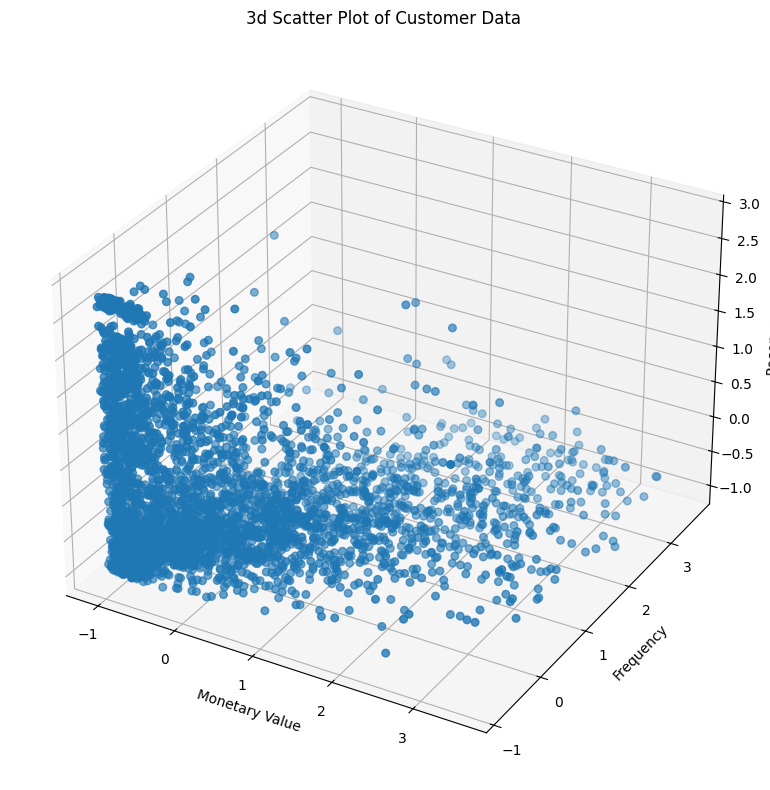

In [58]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(
    scaled_df["MonetaryValue"], 
    scaled_df["Frequency"], 
    scaled_df["RecencyDays"], 
    s=30,
)

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("3d Scatter Plot of Customer Data")

plt.tight_layout()
plt.show()

That's much better! Now all our feature variables are between the range of `[-1, 3]`.

It's worth noting that we haven't just used feature scaling to view our data, it has other benefits too, specifically when using Machine Learning models. For example, it speeds up model training, it can enhance the accuracy of distance-based models like clustering algorithms, helps to prevent feature biases (e.g., large magnitude features, like `MonetaryValue` dominating our model), and improves model interpretability.

Okay, let's move onto to putting this data into clusters!

# K-Means Clustering

To find the optimal number of clusters for our variables, we apply the _elbow_ method. This is done by calculating the inertia (the distance between each data point and its centroid - central/optimal cluster value) of multiple K-Means Clustering algorithms with varing levels of `K`. We can then plot these points and see which acts as an _elbow_ in the graph. 

Let's start by creating our interia values using the K-Means algorithm. We'll also set a random 'seed' to allow for repeatable results.

In [59]:
MAX_K = 15
SEED = 182
ITERATIONS = 500

inertias = []
k_values = range(2, MAX_K + 1)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=SEED, max_iter=ITERATIONS)
    model.fit_predict(scaled_df)
    inertias.append(model.inertia_)

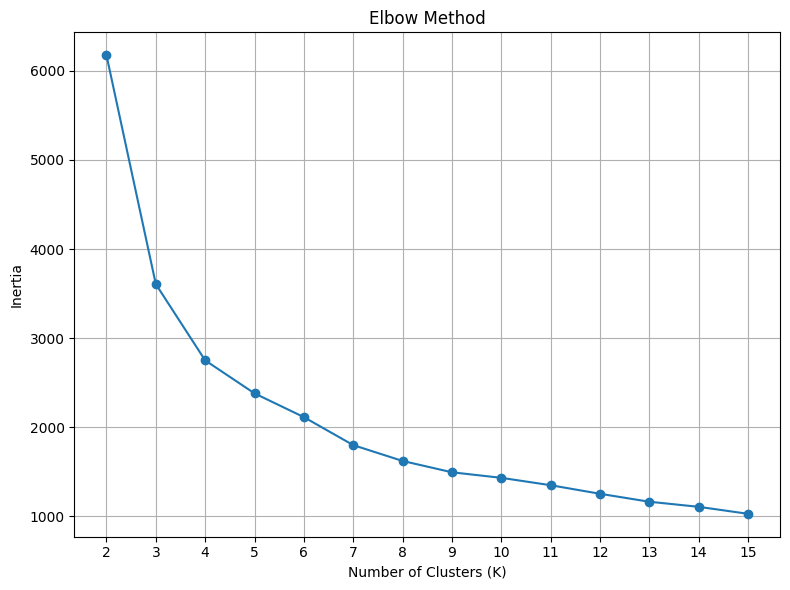

In [60]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")

plt.xticks(k_values)
plt.grid()
plt.tight_layout()
plt.show()

Using a maximum of 15 clusters we can see that the optimal clusters is around 4/5 (this is our elbow point!). But how do we know which one of the two is the best option? 

Let's use another metric to help with that - the `Silhouette Score`. This score ranges between `[-1, 1]` and acts as a measure of quality for our clusters. Higher value = higher quality clusters. In this case, quality relates to variable overlap.

We can use the same code above, but with minor modifications to make this work.

In [61]:
MAX_K = 15
SEED = 182
ITERATIONS = 500

inertias, silhouette_scores = [], []
k_values = range(2, MAX_K + 1)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=SEED, max_iter=ITERATIONS)
    labels = model.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, labels)

    silhouette_scores.append(score)
    inertias.append(model.inertia_)

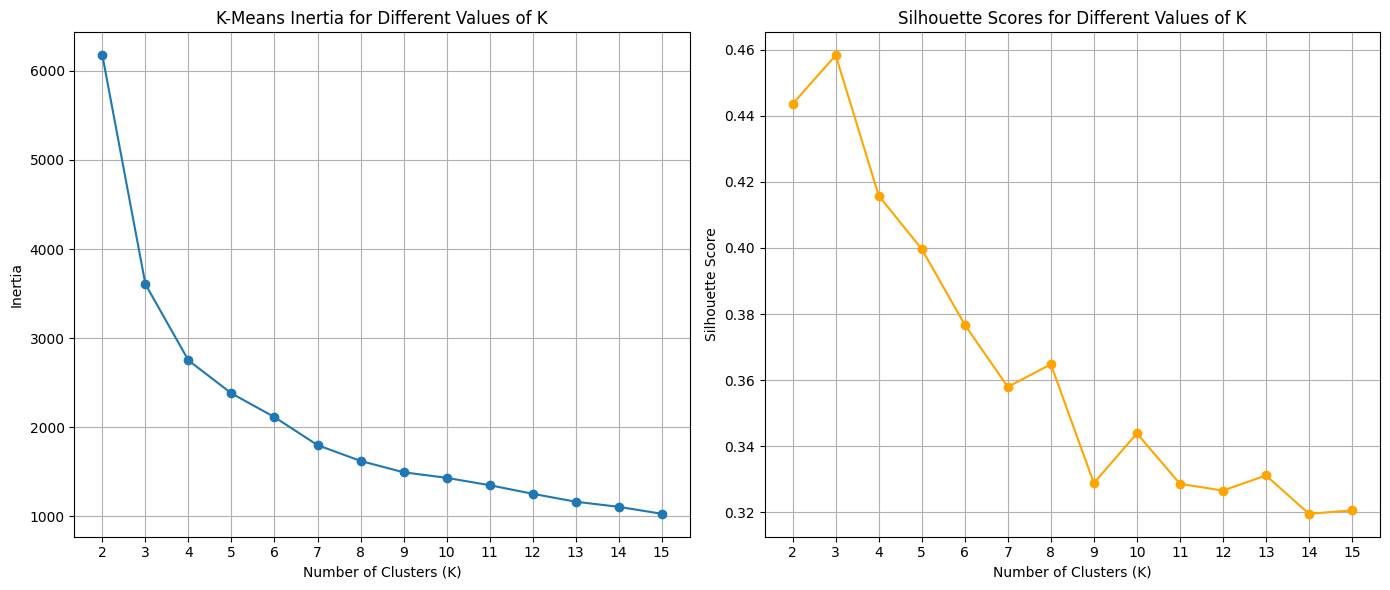

In [62]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.title("K-Means Inertia for Different Values of K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color="orange")
plt.title("Silhouette Scores for Different Values of K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid()

plt.tight_layout()
plt.show()

Combining the two techniques, we can see that 4 provides a higher silhouette score than 5, so we will use that as our optimal K value.

Perfect! Let's get the predicted labels and view our clustered variables!

In [63]:
model = KMeans(n_clusters=4, random_state=SEED, max_iter=ITERATIONS)
labels = model.fit_predict(scaled_df)

In [64]:
non_outliers_df['Cluster'] = labels
non_outliers_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,RecencyDays,Cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,3
2,12348.00,221.16,1,2010-09-27 14:59:00,73,0
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,3
4,12351.00,300.93,1,2010-11-29 15:23:00,10,0
...,...,...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00,17,3
4281,18284.00,411.68,1,2010-10-04 11:33:00,66,0
4282,18285.00,377.00,1,2010-02-17 10:24:00,295,1
4283,18286.00,1246.43,2,2010-08-20 11:57:00,111,3


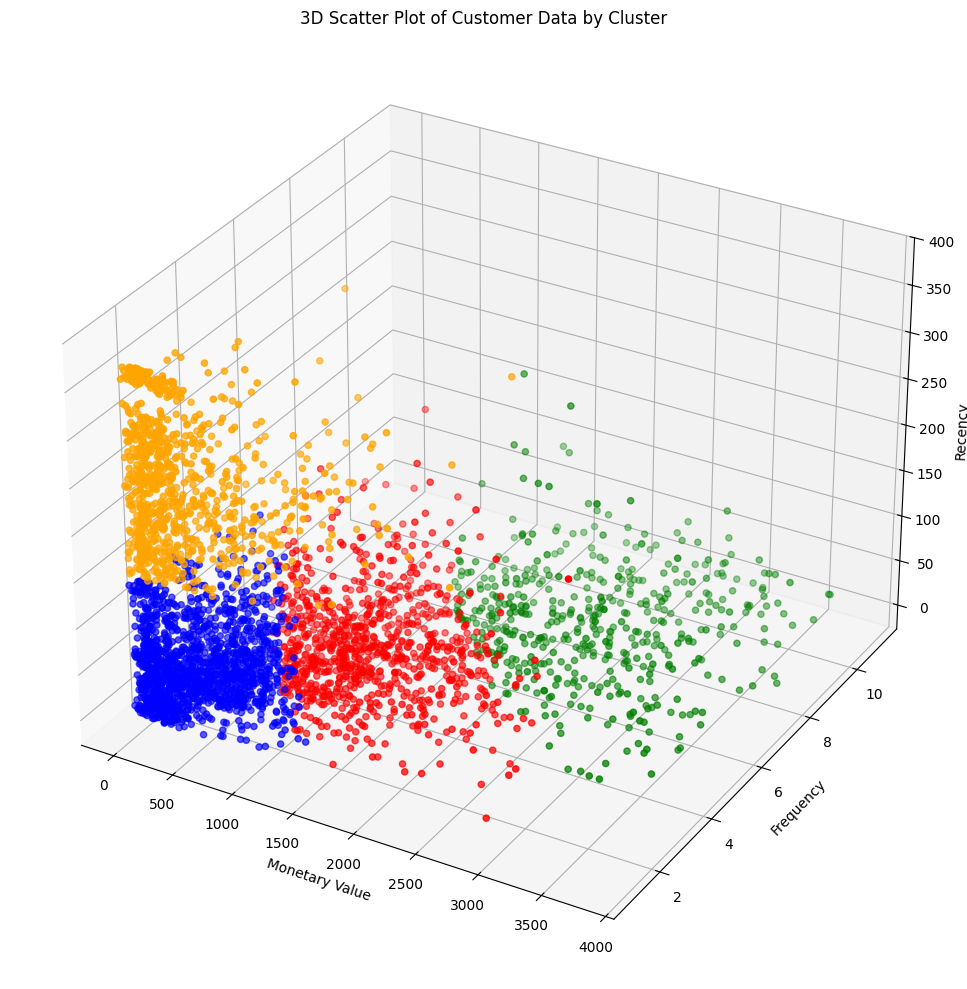

In [65]:
cluster_colors = {
    0: "blue",
    1: "orange",
    2: "green",
    3: "red",
}
colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(
    non_outliers_df["MonetaryValue"], 
    non_outliers_df["Frequency"], 
    non_outliers_df["RecencyDays"], 
    c=colors,
    marker='o'
)

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("3D Scatter Plot of Customer Data by Cluster")

plt.tight_layout()
plt.show()

Now we're talking! Here we can clearly see what variables are related:

- Green - high frequency, high monetary value, low recency
- Red - medium frequency, medium monetary value, low recency
- Blue - low frequency, low monetary value, low recency
- Yellow - medium frequency, low monetary value, high recency

Let's now take a deeper look at these clusters.

# Cluster Analysis

We'll start by exploring a violin plot for each of our variables. These are used to depict the distribution of groups using density curves while providing the same information as a boxplot (IQR, median, etc.). 

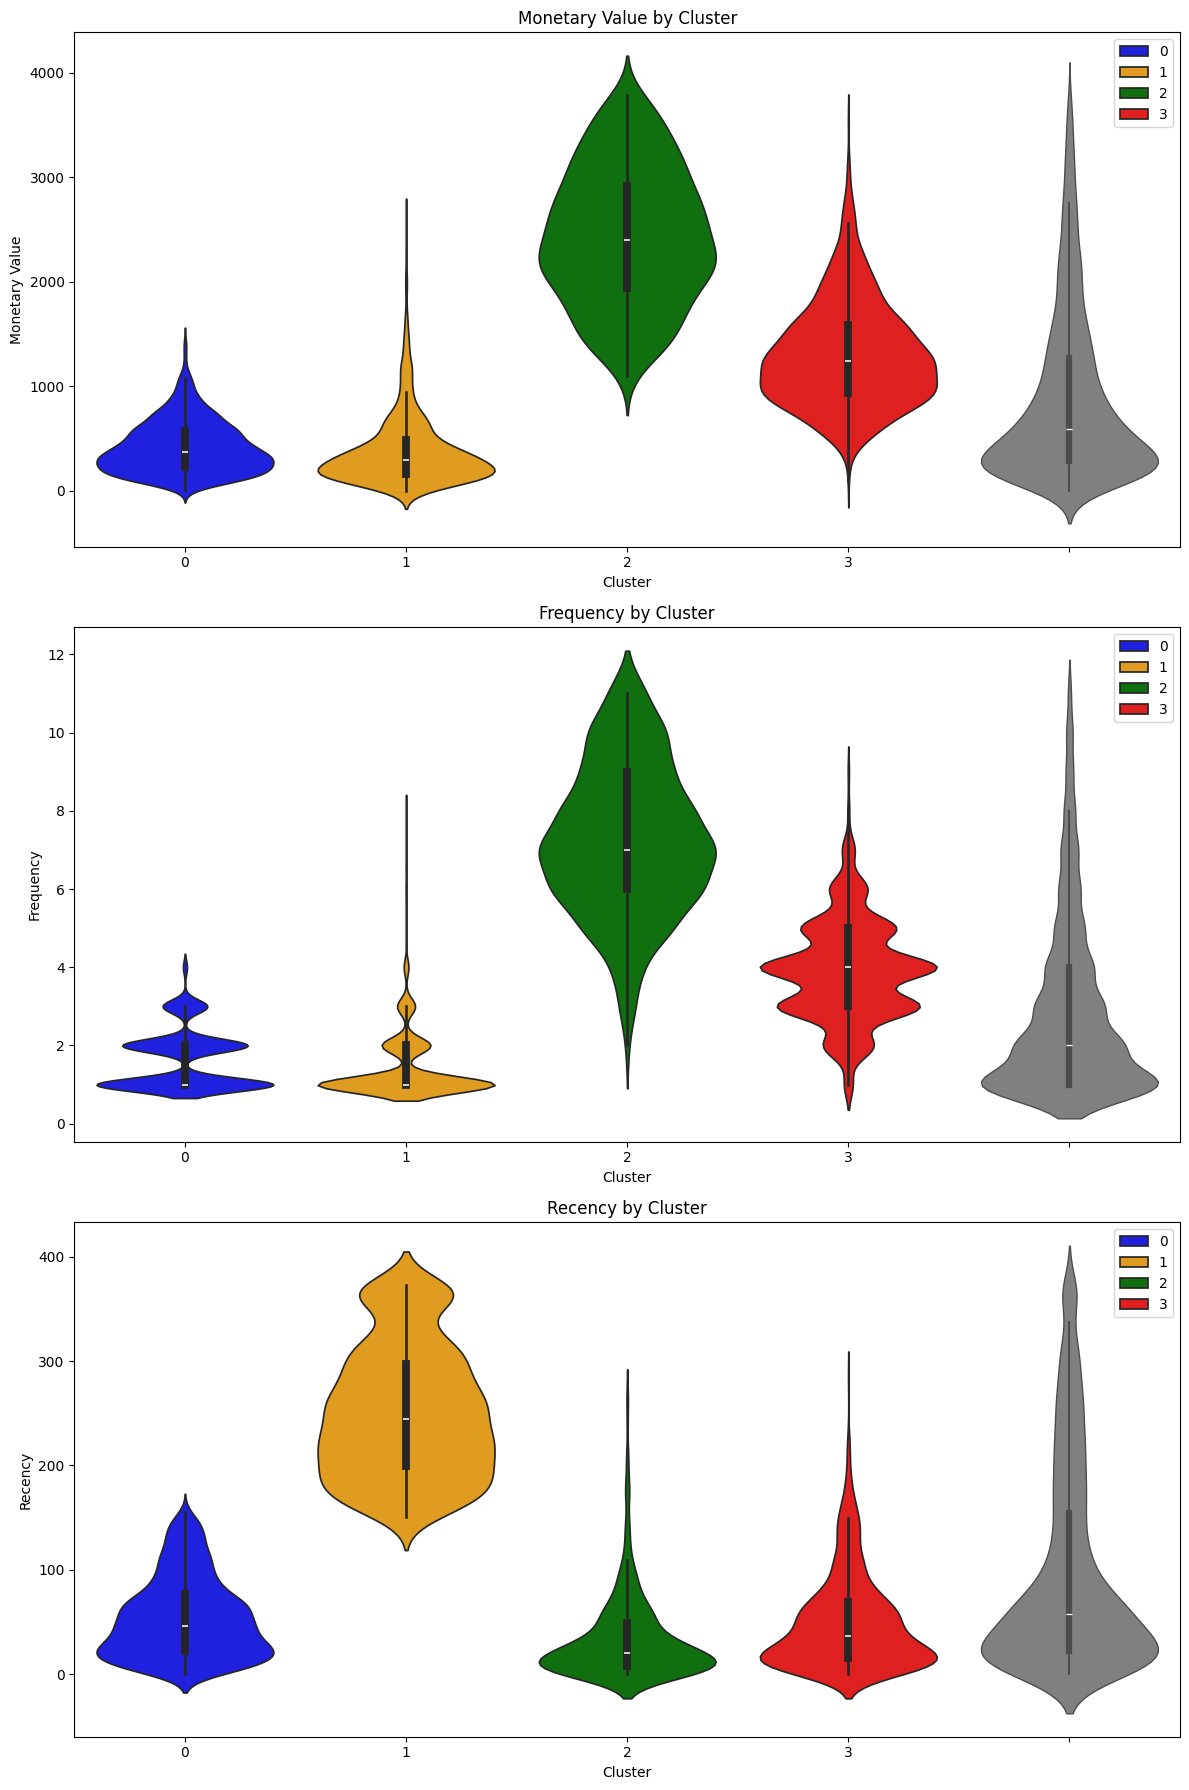

In [68]:
from utils import plot_violins, ViolinDetails

plot_violins(non_outliers_df, details=[
    ViolinDetails(x='Cluster', y='MonetaryValue', palette=cluster_colors, title='Monetary Value by Cluster', xlabel='Cluster', ylabel='Monetary Value'),
    ViolinDetails(x='Cluster', y='Frequency', palette=cluster_colors, title='Frequency by Cluster', xlabel='Cluster', ylabel='Frequency'),
    ViolinDetails(x='Cluster', y='RecencyDays', palette=cluster_colors, title='Recency by Cluster', xlabel='Cluster', ylabel='Recency')
], figsize=(12, 18))

We plot each of the clusters (coloured) and compare it to the original/pre-clustered feature distribution (gray). Given our original synopsis:

- Green - high frequency, high monetary value, low recency
- Red - medium frequency, medium monetary value, low recency
- Blue - low frequency, low monetary value, low recency
- Yellow - medium frequency, low monetary value, high recency
  
Here's what we learn:

### Cluster 0 (Blue) "Nurture"
**Analysis**: Has a lower distribution for monetary value and frequency with a high recency.

**Rationale**: Represents least active and lowest-value customers who made recent purchases. These customers may be new or need nurturing to increase their engagement and spending.

**Action**: Focus on building relationships, providing excellent customer service, and offering incentives to encourage more frequent purchases.

### Cluster 1 (Yellow) "Re-Engage"
**Analysis**: Has a lower distribution for monetary value and frequency with a higher recency.

**Rationale**: Represents lower-value, infrequent buyers who havn't purchased recently. We should aim on re-engagement strategies to bring them back into active purchasers.

**Action**: Use targeted marketing campaigns, special discounts, or reminders to encourage them to return and purchase again.

### Cluster 2 (Green) "Reward"
**Analysis**: Has a higher distribution for monetary value and frequency with a higher recency.

**Rationale**: Represents high-value, very frequent buyers, who are still actively purchasing. These are the most loyal customers and rewarding them is key to maintaining their engagement.

**Action**: Implement loyalty programs, provide exclusive offers, recognise their loyalty to keep them engaged and satisified.

### Cluster 3 (Red) "Retain"
**Analysis**: Has a higher distribution for monetary value and frequency and an equal one for recency. 

**Rationale**: Represents high-value customers who purchase regularly but not always recently. We should aim to retain these customers loyalty and spending levels. 

**Action**: Implement loyalty programs, personalised offers, and regular engagement to ensure they remain active.